In [8]:
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns # in case
import cv2
import os
import rarfile
import pickle 

from joblib import load as joblibLoad
from joblib import dump as joblibdump

from tensorflow.keras import layers, models, optimizers, losses, metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
from sklearn.model_selection import train_test_split
import shutil

source_directory = 'C:\\Users\\thedu\\OneDrive\\Documents\\machine_learning\\CNN_dataset\\extracted_folder\\'

train_dir = './train/'
test_dir = './test/'
val_dir = './validation/'

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

class_directories = [os.path.join(source_directory, f) for f in os.listdir(source_directory)]

for class_dir in class_directories:
    class_name = os.path.basename(class_dir)

    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

    images = [os.path.join(class_dir, img) for img in os.listdir(class_dir)]

    train_images, test_val_images = train_test_split(images, test_size=0.2, random_state=42)
    test_images, val_images = train_test_split(test_val_images, test_size=0.5, random_state=42)

    for img in train_images:
        shutil.copy(img, os.path.join(train_dir, class_name, os.path.basename(img)))

    for img in test_images:
        shutil.copy(img, os.path.join(test_dir, class_name, os.path.basename(img)))

    for img in val_images:
        shutil.copy(img, os.path.join(val_dir, class_name, os.path.basename(img)))

In [10]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_dataset = train_datagen.flow_from_directory(
    'C:\\Users\\thedu\\OneDrive\\Documents\\machine_learning\\CNN_dataset\\train', 
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb',
    seed=42
)

val_dataset = train_datagen.flow_from_directory(
    'C:\\Users\\thedu\\OneDrive\\Documents\\machine_learning\\CNN_dataset\\validation',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb',
    seed=42
)

test_dataset = train_datagen.flow_from_directory(
    'C:\\Users\\thedu\\OneDrive\\Documents\\machine_learning\\CNN_dataset\\test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb',
    seed=42
)

Found 2596 images belonging to 8 classes.
Found 328 images belonging to 8 classes.
Found 324 images belonging to 8 classes.


In [11]:
test_dataset.image_shape

(224, 224, 3)

- `create_model` creates a `CNN` using `keras`
- We have 3 layers of `convolutional filters` at `64`, `128` and `256`.
- We did try using 4 to 5 layers with of `convolutional filters` at  `64`, `128`, `256`, `512` and `1024` respectively but it resulted in a lower accuracy.

- `accuracy` with `3 epochs` and `5 conv2d layers`<br>
![accuracy_epoch3_layer5](https://cdn.discordapp.com/attachments/1160530410460151899/1181899831195738172/image.png?ex=6582bcfe&is=657047fe&hm=7264c33cc1df475b11a38350a418ba1a2fc18f3fee87bc4eed16a0eb3db585f7&)

- `accuracy` with `3 epochs` and `3 conv2d layers`<br>
![accuracy_epoch3_layer3](https://media.discordapp.net/attachments/1160530410460151899/1181926412207272026/image.png?ex=6582d5bf&is=657060bf&hm=b5719051ca2aa892e55386c4d3337ed56e43711d2ab4def9e3d7b2bdd0560d5f&=&format=webp&quality=lossless)

- `model.add(layers.Flatten())` we flatten the output of `conv2d` to transform the `2D feature` to a `1D vector`. This allows the neural network to learn form the spatial features that were extracted from the `conv2d layers`

- We add a fully connected layers with `256` units and a dropout of `0.3`

- We then add an output layer with `8 units` and `softmax activation` for `multi-class` classification

- We also define the `metrics` of the output which will be `CategoricalAccuracy`, `Recall`, `Precision`, `AUC`, `TruePositives`, `TrueNegatives`, `FalseNegatives`, `FalsePositives`



In [12]:
def create_model(activation, dimension):
    model = models.Sequential()
    model.add(layers.InputLayer(dimension))

    # Architecture with 3 layers
    model.add(layers.Conv2D(64, 3, activation=activation, padding='same'))
    model.add(layers.MaxPooling2D(pool_size=2, padding='valid'))

    model.add(layers.Conv2D(128, 3, activation=activation, padding='same'))
    model.add(layers.MaxPooling2D(pool_size=2, padding='valid'))

    model.add(layers.Conv2D(256, 3, activation=activation, padding='same'))
    model.add(layers.MaxPooling2D(pool_size=2, padding='valid'))

    # Flatten
    model.add(layers.Flatten())

    # FCN
    model.add(layers.Dense(256, activation=activation))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(256, activation=activation))
    model.add(layers.Dropout(0.3))

    # Output
    model.add(layers.Dense(8, activation='softmax'))

    model.summary()
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.0001),
        loss=losses.CategoricalCrossentropy(from_logits=False),
        metrics=[
            metrics.CategoricalAccuracy(),
            metrics.Recall(),
            metrics.Precision(),
            metrics.AUC(),
            metrics.TruePositives(),
            metrics.TrueNegatives(),
            metrics.FalseNegatives(),
            metrics.FalsePositives()
        ]
    )

    return model

In [13]:
model = create_model('relu',train_dataset.image_shape)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 256)       295168    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 28, 28, 256)      

- We train the neural network using `train_dataset` for `30 epochs`

In [14]:
history = model.fit(
    train_dataset,
    steps_per_epoch=train_dataset.samples // train_dataset.batch_size,
    epochs=30,
    validation_data=val_dataset,
    validation_steps=val_dataset.samples // val_dataset.batch_size
)

Epoch 1/30

81/81 [==============================] - 136s 2s/step - loss: 1.9881 - categorical_accuracy: 0.1923 - recall: 0.0000e+00 - precision: 0.0000e+00 - auc: 0.6348 - true_positives: 0.0000e+00 - true_negatives: 17946.0000 - false_negatives: 2564.0000 - false_positives: 2.0000 - val_loss: 1.7561 - val_categorical_accuracy: 0.4219 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.7884 - val_true_positives: 0.0000e+00 - val_true_negatives: 2240.0000 - val_false_negatives: 320.0000 - val_false_positives: 0.0000e+00
Epoch 2/30
81/81 [==============================] - 129s 2s/step - loss: 1.5127 - categorical_accuracy: 0.4345 - recall: 0.1431 - precision: 0.6661 - auc: 0.8310 - true_positives: 367.0000 - true_negatives: 17764.0000 - false_negatives: 2197.0000 - false_positives: 184.0000 - val_loss: 1.0261 - val_categorical_accuracy: 0.6875 - val_recall: 0.3469 - val_precision: 0.9024 - val_auc: 0.9376 - val_true_positives: 111.0000 - val_true_negatives: 2228.0000 - val

In [15]:
# Save the training history to a file
history_file_path = 'C:\\Users\\thedu\\OneDrive\\Documents\\machine_learning\\CNN_dataset\\results\\history_DL_example.pkl'
with open(history_file_path, 'wb') as file:
    pickle.dump(history.history, file)

In [16]:
# Save the model in the native Keras format
model_file_path = 'C:\\Users\\thedu\\OneDrive\\Documents\\machine_learning\\CNN_dataset\\results\\DL_example'
model.save(model_file_path)

INFO:tensorflow:Assets written to: C:\Users\thedu\OneDrive\Documents\machine_learning\CNN_dataset\results\DL_example\assets


INFO:tensorflow:Assets written to: C:\Users\thedu\OneDrive\Documents\machine_learning\CNN_dataset\results\DL_example\assets


In [17]:
# Load the training history from the file
with open(history_file_path, 'rb') as f:
    history = pickle.load(f)

In [18]:
print(history)

{'loss': [1.9881258010864258, 1.5127222537994385, 1.0879045724868774, 0.8201891183853149, 0.6822142601013184, 0.5599010586738586, 0.47338423132896423, 0.3940613567829132, 0.29764828085899353, 0.2772681415081024, 0.19630670547485352, 0.18310678005218506, 0.18217915296554565, 0.14266705513000488, 0.12729378044605255, 0.10242874920368195, 0.1006731316447258, 0.07377839833498001, 0.0695771649479866, 0.06241666525602341, 0.05698224529623985, 0.05988319590687752, 0.038892634212970734, 0.042775996029376984, 0.04656016454100609, 0.04523557424545288, 0.054107118397951126, 0.04861397668719292, 0.042651548981666565, 0.04396958276629448], 'categorical_accuracy': [0.1922776848077774, 0.43447738885879517, 0.5998439788818359, 0.6942277550697327, 0.7574102878570557, 0.7956318259239197, 0.8311232328414917, 0.8638845682144165, 0.8946957588195801, 0.9052262306213379, 0.9305772185325623, 0.9372074604034424, 0.9411076307296753, 0.951248049736023, 0.9567082524299622, 0.9664586782455444, 0.9695788025856018, 

In [19]:
from matplotlib import pyplot as plt

- Here we plot `loss` which is the value of the `loss function`
- This quantifies the difference between the `predicted values` and the `actual values` during training
- The decrease in `loss` over `epochs` signifies that model is learning

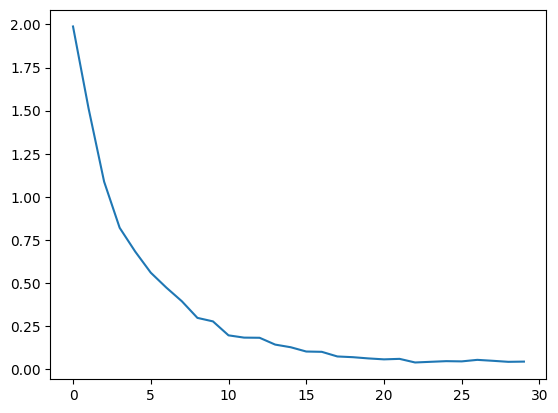

In [20]:
plt.plot(history['loss'])

- Here we are plotting `val_loss` over `epochs`
- This shows how well the model is generalizing to new data

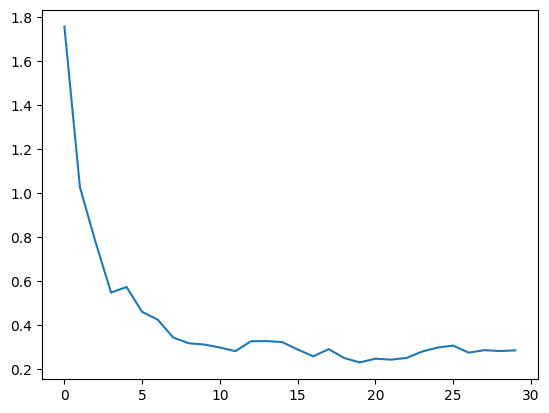

In [37]:
plt.plot(history['val_loss'])

- Here we are plottign the `categorical_accuracy` over `epochs`
- `categorical_accuracy` measures the proportion of `correctly classified samples` out of the total number of samples
- This is a good way to evaluate the performance of the model

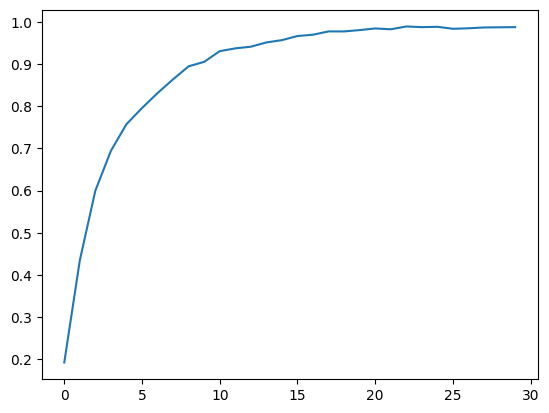

In [21]:
plt.plot(history['categorical_accuracy'])

- Here we are plotting `val_categorical_accuracy` over `epochs`
- `val_categorical_accuracy`is similar to `categorical_accuracy` but it runs them over the `validation samples`

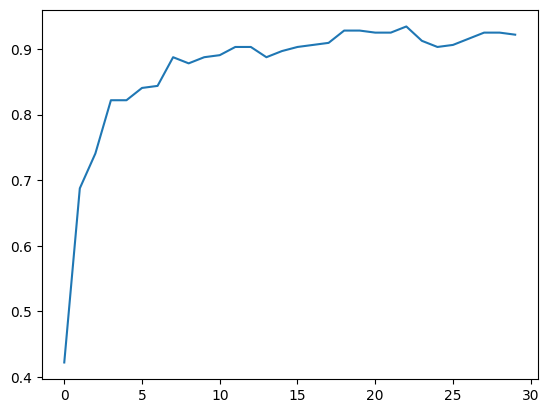

In [38]:
plt.plot(history['val_categorical_accuracy'])

- Here we plot the `recall` value over `epochs`
- `recall` represent the proportion of `actual positive` cases that are correctly identified by the model
- A high `recall` value indicates that the model is effectively identifying the actual positive cases

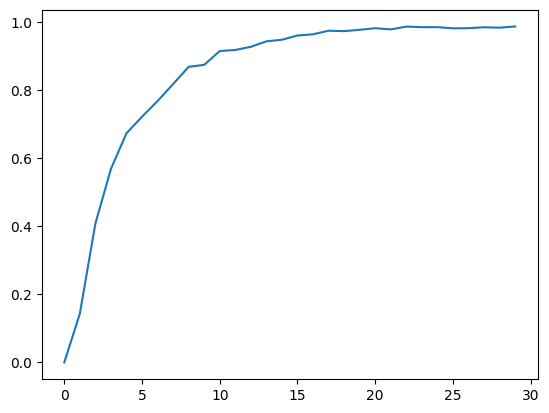

In [23]:
plt.plot(history['recall'])

- Here we are plotting `AUC` `area under the ROC curve` over `epochs`
- This represents the degree of `seperability` or the models ability to distinguish between classes.

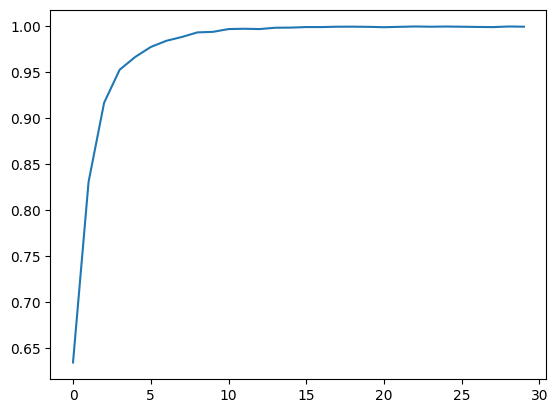

In [40]:
plt.plot(history['auc'])

- Here we plot `precision` over `epochs`
- This represents the proportion of `true positives` out of all `positive predictions` that the model made

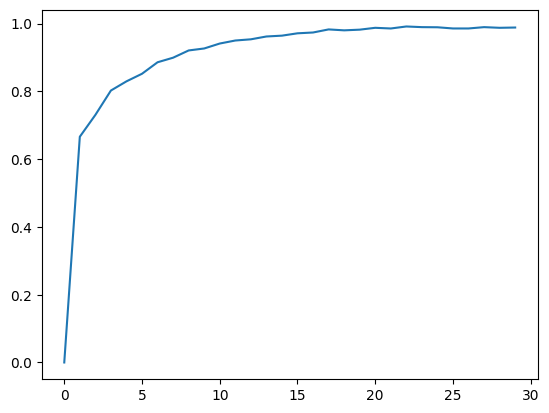

In [26]:
plt.plot(history['precision'])

- The `get_best_epoch` function calculates the best `epoch` based on `precision` and `recall` values of each `epoch`
- It first finds the `epoch` with the highest `precision` and `epoch` with the highest `recall`
- It then selects the `epoch` with the highest `precision` and `recall` and returns the value of the `epoch`
- It also calculates the value of the `f1 score` based on the `epoch`

In [27]:
def get_best_epoch(history):
    max_precision_epoch = history['precision'].index(max(history['precision'])) + 1
    max_recall_epoch = history['recall'].index(max(history['recall'])) + 1
    best_epoch = min(max_precision_epoch, max_recall_epoch)
    precision_at_best_epoch = history['precision'][best_epoch - 1]
    recall_at_best_epoch = history['recall'][best_epoch - 1]
    f1_score = 2 * (precision_at_best_epoch * recall_at_best_epoch) / (precision_at_best_epoch + recall_at_best_epoch)
    print("Best epoch with highest precision and recall:", best_epoch)
    print("Precision at best epoch:", precision_at_best_epoch)
    print("Recall at best epoch:", recall_at_best_epoch)
    print(f"F1 Score: {f1_score}")


get_best_epoch(history)

Best epoch with highest precision and recall: 23
Precision at best epoch: 0.9913826584815979
Recall at best epoch: 0.9871295094490051
F1 Score: 0.9892515125310221


- Due to the very high `f1 score` we got `0.989`, we suspected that the model had begun to `overfit`. As such, me made a function that would detect if the model had begun to overfit
- This is done by checking for overfitting based on `loss` by comparing the trend of `validation_loss` and `training_loss`. If the validation loss consistently increases while the trainingl loss decreases, it would indicate that there is overfitting occuring based on loss
- If no overfitting is detected based on loss, it then checks for overfitting based on `accuracy`. It looks for a point where `val_categorical accuracy` starts decreasing while `training_categorical_accuracy` continues to increase. If so it indicates that there is overfitting occuring based on `accuracy`.
- The function then returns the result as well as the `epoch` which had overfitting.

In [39]:
def detect_overfitting(history):
    training_loss = history['loss']
    validation_loss = history['val_loss']
    training_accuracy = history['categorical_accuracy']
    validation_accuracy = history['val_categorical_accuracy']

    loss_overfitting = all(validation_loss[i] > validation_loss[i-1] for i in range(1, len(validation_loss))) and all(training_loss[i] < training_loss[i-1] for i in range(1, len(training_loss)))
    accuracy_overfitting = all(validation_accuracy[i] <= validation_accuracy[i-1] for i in range(1, len(validation_accuracy))) and all(training_accuracy[i] > training_accuracy[i-1] for i in range(1, len(training_accuracy)))

    if loss_overfitting:
        return "Warning: Overfitting detected based on loss"
    elif accuracy_overfitting:
        overfit_epoch = next((i+1 for i in range(len(validation_accuracy)-1) if validation_accuracy[i] <= validation_accuracy[i+1]), None)
        if overfit_epoch:
            return "Model starts to overfit at epoch {overfit_epoch}"
        else:
            return "No overfitting detected based on accuracy"
    else:
        return "No overfitting detected"

overfitting_result = detect_overfitting(history)
print(overfitting_result)

No overfitting detected
